<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 2</h1>

**Use popular pretrained architectures for transfer learning and show comparison of results**

# Getting the data

In [1]:
# Don't run this cell if not using google colab and kaggle.json is in place.
from google.colab import files
# kaggle.json file is required to obtain the dataset from kaggle
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


In [0]:
import kaggle
from pathlib import Path

In [3]:
data = Path("./data")
if not data.exists():
    data.mkdir()
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files("tongpython/cat-and-dog",path=data,quiet=False,unzip=True,force=False)

  0%|          | 0.00/218M [00:00<?, ?B/s]

100%|██████████| 218M/218M [00:03<00:00, 58.8MB/s]


# Readying the data
- Creating train and test dataloaders.
- Train dataset will have ColorJitter applied to it.

In [0]:
import time
import torch
import numpy as np
np.random.seed(34)

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage, ToTensor, ColorJitter, CenterCrop, Normalize, Resize, Compose

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

Tesla T4


In [0]:
def get_mean_std(ds):
    """
    Gets mean and std of an ImageFolder (instance) dataset.
    """
    means = []
    stds = []
    for d in ds:
        means.append(d[0].mean(axis=(2,1)).numpy())
        stds.append(d[0].std(axis=(2,1)).numpy())
    mean = np.array(means).mean(axis=0)
    std = np.array(stds).mean(axis=0)
    return mean, std

class CatDogDataset(ImageFolder):
    """
    Custom dataset designed so that images can be viewed.
    """
    def __init__(self,root, mean, std,**kwargs):
        self.class_labels = ['cat','dog']
        self.topil = ToPILImage()
        self.norm = Normalize(mean, std)
        super().__init__(root, **kwargs)
    
    def image(self,idx):
        img, l = super().__getitem__(idx)
        return self.topil(img),self.class_labels[l]
    
    def __getitem__(self,idx):
        item = super().__getitem__(idx)
        return self.norm(item[0]),item[1]

Find mean and std of off the train dataset

In [7]:
# mean =  np.array([0.48826352,0.45509255,0.4174077])
# std =   np.array([0.22981022,0.22478424,0.22537524])

# Takes time to run cause > 8000 images, also there may be a better way to do this
temp_ds = ImageFolder(data/'training_set/training_set',transform=ToTensor())
mean, std = get_mean_std(temp_ds) 
print("mean: ",*mean)
print("std:  ",*std)

mean:  0.48826352 0.45509255 0.4174077
std:   0.22981022 0.22478424 0.22537524


In [0]:
training_transforms = Compose([
    ColorJitter(0.3,0.3,0.3),
    Resize(256),
    CenterCrop(224),
    ToTensor()
])
testing_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

ds_train = CatDogDataset(data/'training_set/training_set',mean ,std ,transform=training_transforms)
ds_test_all = CatDogDataset(data/'test_set/test_set',mean ,std ,transform=testing_transforms)

- Generating indices for the subset sampler to divide test set into test and valid.  
- Selecting test set here because test set size is 25% of train set.  
- Valid set is 0.2 of test set (404 samples, striated)

In [0]:
valid_percent = 0.2
valid_size = int(0.2 * len(ds_test_all))

cat_idx = np.random.permutation(np.arange(0,1011))[:int(valid_size/2)]
dog_idx = np.random.permutation(np.arange(1012,2023))[:int(valid_size/2)]

valid_idx = np.concatenate([cat_idx,dog_idx])
test_idx = np.array(list(filter(lambda x: x not in valid_idx, np.arange(len(ds_test_all)))))

ds_test = Subset(ds_test_all, test_idx)
ds_valid = Subset(ds_test_all, valid_idx)

Create Dataloaders for all datasets.

In [10]:
dl_train,dl_valid,dl_test = [DataLoader(ds,64,shuffle=True) for ds in [ds_train, ds_valid, ds_test]]
sets = ['tr','va','te']
TR,VA,TE = sets

for name,dl in zip(['train','valid','test'],[dl_train,dl_valid,dl_test]):
    print(name.ljust(5),len(dl.dataset))
    
dl = {s[0]:s[1] for s in zip(sets,[dl_train,dl_valid,dl_test])}

train 8005
valid 404
test  1619


Create small datasets, loaders for testing hyper params

In [11]:
sz = 10
micro_tr = np.concatenate([cat_idx[:sz*2],dog_idx[:sz*2]+4000])
micro_va = np.concatenate([cat_idx[:sz],dog_idx[:sz]])

dl_micro = {
    TR: DataLoader(Subset(ds_train,micro_tr),5,shuffle=True),
    VA: DataLoader(Subset(ds_test_all,micro_va),5,shuffle=True)
}

len(dl_micro[TR].dataset), len(dl_micro[VA].dataset)

(40, 20)

# Checking some test samples

In [0]:
import matplotlib.pyplot as plt

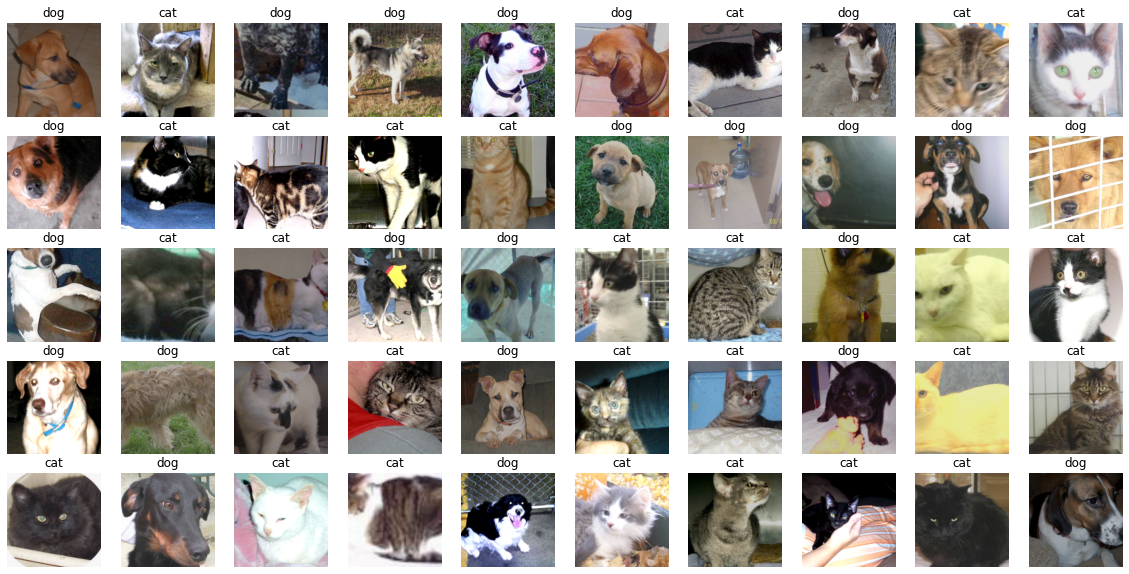

In [13]:
r,c = 5,10
rand_idx = np.random.randint(0,len(ds_train),r*c)

plt.figure(figsize=(20,10))
for i,idx in enumerate(rand_idx):
    img, lbl = ds_train.image(idx)
    plt.subplot(r,c,i+1)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img)

___

# Getting Inception Resnet v2
There is no pytorch implementation for this model so getting it from [Cadene/pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/inceptionresnetv2.py)

In [0]:
import requests
import torch
import torch.nn as nn

In [0]:
irv2_url = "https://raw.githubusercontent.com/Cadene/pretrained-models.pytorch/master/pretrainedmodels/models/inceptionresnetv2.py"
irv2_path = data/"inceptionresnetv2.py"
if not irv2_path.exists():
    content = requests.get(irv2_url).content
    irv2_path.open('w').write(content.decode('utf-8'))

# Loading the models


All the models used here except Inception Resnet V2 are provided through the `pytorch.models` module.

All the models have been trained on [ImageNet](http://www.image-net.org/) which is a dataset of ~14M images having 1k classes.

The pretrained weights have to be downloaded as only the model definition comes installed.

In [0]:
from torchvision import models
from data.inceptionresnetv2 import inceptionresnetv2

In [17]:
pretrained = True

resnet_50 = models.resnet50(pretrained)
resnext50 = models.resnext50_32x4d(pretrained)
wresnet50 = models.wide_resnet50_2(pretrained)
incresnv2 = inceptionresnetv2()

# The model definition has kernel_size set as 8 which may be a typo
# ∵ the previous layer has W and H of 5.
incresnv2.avgpool_1a = nn.AvgPool2d(kernel_size=(5, 5),
                                    count_include_pad=False)

try:
    del old_fc
except:
    pass

pt_resnets = [resnet_50, resnext50, wresnet50]
pt_resnets_names = ['resnet50','resnext50','wresnet50']

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth


# Readying models for Transfer Learning

The last fully connected layer of the network is removed and replaced with one that suits the purpose which in this case is a acat dog classifier.

So the output the network will be `(m, 2)` it can be a single `(m, 1)` where the prob for the second class will be $1 - \hat{y}$.

In [0]:
"""
Altering the pytorch resnets as all have the same last
fully connected layer labelling
"""
# Prevent all layers from training.
def freeze_all_layers(net):
    for params in net.parameters():
        params.requires_grad = False

def replace_fc(nets, old_fc):
    out_features = 2
    for net in nets:
        old_fc.append(net.fc)
        in_features = net.fc.in_features
        fc = nn.Sequential(
            nn.Linear(in_features,out_features),
            nn.Softmax(dim=1)
        )
        net.fc = fc
        for params in net.fc.parameters():
            params.requires_grad = True
    
for net in pt_resnets:
    freeze_all_layers(net)
    
try:
    if len(old_fc) == 0:
        replace_fc(pt_resnets, old_fc)
    else:
        print('already replaced')
except:
    old_fc = []
    replace_fc(pt_resnets, old_fc)


In [0]:
"""
Altering the inception resnet v2
"""
freeze_all_layers(incresnv2)

in_features = incresnv2.last_linear.in_features
out_features = 2
incresnv2.last_linear = nn.Sequential(
            nn.Linear(in_features,out_features),
            nn.Softmax(dim=1)
        )

for params in incresnv2.last_linear.parameters():
    params.requires_grad == True

# Helper Functions

## Fit Functions

In [0]:
# A simple fit function without any logging
def simple_fit(model,dl,optim,loss_func,epoch=10):
    model = model.to(device)
    losses = []
    for e in range(epoch):
        r_loss = 0
        for X,y in dl:
            bs = y.size(0)
            X = X.to(device)
            y = y.to(device)

            optim.zero_grad()
            y_ = model(X)
            loss = loss_func(y_,y)
            loss.backward()
            optim.step()
            r_loss += loss.item() * bs
        losses.append(r_loss/len(dl.dataset))
    return losses

# A verbose fit function with logging.
def fit(model, optim, sched, loss_func, dl, epochs=1, is_test=False):
    model = model.to(device)

    # Test batch multipliers
    tb_t,tb_v = 6,2

    # To switch between training and validation
    phases = [TR, VA]

    # Measure total time
    tot_time = time.time()

    # Record metrics
    losses = {TR:[], VA:[]}
    accuracies = {TR:[], VA:[]}

    # Dataset sizes for accu and loss calcualtions
    sizes = {ph: len(dl[ph].dataset) for ph in phases}
    if is_test:
        sizes[TR] = tb_t * dl[TR].batch_size
        sizes[VA] = tb_v * dl[VA].batch_size
    
    # Init markers
    least_loss = float('inf')
    best_accu = 0
    best_model = deepcopy(model.state_dict())
    
    for e in range(epochs):
        # Measure the epoch time (train + valid)
        epo_time = time.time()

        # Print epoch counter
        epoch_st = f"[{e+1}/{epochs}]".rjust(len(str(epochs))*2+3)
        print(f"{epoch_st} | ",end="")
        if is_test:
            print("[", end="")
        
        for phase in phases:
            # Running metrics, caluclate as they come in
            running_loss = 0
            running_corr = 0

            # bool checker used ahead for updating markers and optimizer step
            is_tr = phase == TR

            # Iterate over training or validation batch
            for b_num,batch in enumerate(dl[phase]):

                # Limit batches if testing fit function
                if is_test:
                    if is_tr:
                        print(b_num,end=" ")
                        if b_num == tb_t:
                            break
                    elif not is_tr and b_num == tb_v:
                        break
                    else:
                        pass

                # Get data and batch size
                X,y = batch
                bs = y.size(0)
                
                # Shift data to device (when GPU)
                X = X.to(device)
                y = y.to(device)
                    
                # Reset gradients to zero
                optim.zero_grad()
                
                # Sets model.eval or model.train depending on bool
                with torch.set_grad_enabled(is_tr):

                    # Forward pass 
                    y_pred = model(X)

                    # Calculate loss using loss_function 
                    loss = loss_func(y_pred,y)

                    # Update weights only if trianing phase
                    if is_tr:
                        loss.backward()
                        optim.step()
                        
                    # Update lr if validation loss don't change none
                    if not is_tr:
                        if isinstance(sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
                            sched.step(loss.item())
                        else:
                            sched.step()
                
                # Deaverage the loss and get correct predictions
                batch_loss = loss.item() * bs
                batch_corr = (y_pred.argmax(dim=1) == y).sum().item()
                # Add to running metrics
                running_loss += batch_loss
                running_corr += batch_corr
            if is_test and is_tr:
                print('] | ',end="")
                

            # Calculate epochal loss and accu
            epo_loss = running_loss / sizes[phase]
            epo_accu = running_corr / sizes[phase]
            
            # Print epochal metrics
            print(f"{phase} :: loss: {epo_loss:0.4f} accu: {epo_accu:0.4f} | ", end="")
            
            # Store metrics
            losses[phase].append(epo_loss)
            accuracies[phase].append(epo_accu)
            
            # Update markers if not training
            if not is_tr:
                if epo_accu > best_accu:
                    best_accu = epo_accu
            
                if epo_loss < least_loss:
                    least_loss = epo_loss
                    best_model = deepcopy(model.state_dict())
            
        # Print time taken by epoch
        end_time = np.round(time.time() - epo_time,3)
        s,ms = str(end_time).split('.')
        print(f"time {s} s {ms} ms")

    # Restore "best" model, print total time and metrics.
    model.load_state_dict(best_model)
    end_time = np.round(time.time() - tot_time,3)
    s,ms = str(end_time).split('.')
    print(f"best accuracy: {best_accu:0.4f} least loss: {least_loss:0.4f}")
    print(f"time {int(s)//60} m {int(s)%60} s {ms} ms")

    return losses, accuracies

## Metric Helpers

In [0]:
# Function to check the accuracy and loss of a model.
def check_accu(model, dl_test, verbose=True, loss_func=nn.CrossEntropyLoss()):
    
    model = model.to(device)
    model.eval()
    
    bs = dl_test.batch_size
    size = len(dl_test.dataset)
    batch_count = size//bs
    
    corrects = 0
    losses = 0
    percent = 0
    if verbose:
        print(f"batches ({batch_count}): ",end="\n\t")
    for i,batch in enumerate(dl_test):
        with torch.no_grad():
            X,y = batch
            if verbose:
                print(str(i).rjust(len(str(batch_count))+1),end="")
                if ((i+1) % 25) == 0:
                    print(end="\n\t")

            b = len(y)
            X = X.to(device)
            y = y.to(device)
            y_ = model(X)

            losses += loss_func(y_,y).item() * b
            corrects += (y_.argmax(dim=1)==y).sum().item()
    loss, accu = losses/size, corrects/size
    if verbose:
        print(f"\nloss: {loss:0.4f} accuracy: {accu:0.4f}")
    return loss, accu


# Check for learning rates
def net_tester(name,model,dl,test_epochs,lr_list, reseter=None):
    losses_list = []
    metric_list = []
    for lr in lr_list:
        loss_func = torch.nn.CrossEntropyLoss()
        if name == 'inceptionresnetv2':
            optim = torch.optim.Adam(model.last_linear.parameters())
        else:
            optim = torch.optim.Adam(model.fc.parameters())
        # Obtain the metrics
        losses_ = simple_fit(model,dl,optim,loss_func,epoch=test_epochs)
        loss_, accu_ = check_accu(model,dl,False)

        if reseter is not None:
            reseter()

        # Store the metrics
        losses_list.append(losses_)
        metric_list.append((loss_,accu_))

        # Disply the metrics
        print(f"lr: {lr}\tloss: {loss_}   accu: {accu_}")
        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.plot(np.arange(len(losses_)),losses_)
        plt.show()
    return losses_list, metric_list

___

# Get Baseline Metrics

The baseline metrics will help in comparison.

## Save the state dicts for later use (maybe)

In [0]:
from copy import deepcopy

In [0]:
"""
Run this cell only once after loading the pretrained weights.
Else pretrained weights will be overwritten.
"""

all_nets = [*pt_resnets, incresnv2]
all_nets_names = [*pt_resnets_names, 'inceptionresnetv2']
    
nets = {all_nets_names[i]:all_nets[i] for i in range(len(all_nets))}
nets_sd = {k:deepcopy(nets[k].state_dict()) for k in nets}

In [0]:
def load_sd(nets, nets_sd):
    for k in nets:
        nets[k].load_state_dict(deepcopy(nets_sd[k]))

def check_all_accu(nets, dl):
    for k in nets:
        loss, accu = check_accu(nets[k],dl,False)
        print(f"{k.ljust(18)}: loss {loss}  accu {accu}")

def reseter():
    load_sd(nets, nets_sd)

In [0]:
load_sd(nets, nets_sd)

## Get initial accuracy and loss

In [29]:
check_all_accu(nets, dl[TE])

resnet50          : loss 0.694  accu 0.501
resnext50         : loss 0.705  accu 0.468
wresnet50         : loss 0.683  accu 0.581
inceptionresnetv2 : loss 0.684  accu 0.476


## Get running times

In [0]:
def check_time_single_epoch_time(dl):
    for name in nets:
        net = nets[name] 
        loss_func = nn.CrossEntropyLoss()
        if name == 'inceptionresnetv2':
            optim = torch.optim.Adam(net.last_linear.parameters())
        else:
            optim = torch.optim.Adam(net.fc.parameters())
        sched = torch.optim.lr_scheduler.StepLR(optim,10,0.5)
        
        print(f"NETWORK: {name}")
        _ = fit(net, optim, sched, loss_func, dl, is_test=True)    
        print()
    load_sd(nets, nets_sd)

In [27]:
check_time_single_epoch_time(dl)

NETWORK: resnet50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.5163 accu: 0.8672 | va :: loss: 0.4525 accu: 0.9453 | time 10 s 303 ms
best accuracy: 0.9453 least loss: 0.4525
time 0 m 10 s 342 ms

NETWORK: resnext50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.5662 accu: 0.7344 | va :: loss: 0.5159 accu: 0.8281 | time 12 s 752 ms
best accuracy: 0.8281 least loss: 0.5159
time 0 m 12 s 796 ms

NETWORK: wresnet50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.6044 accu: 0.7682 | va :: loss: 0.5221 accu: 0.9219 | time 13 s 886 ms
best accuracy: 0.9219 least loss: 0.5221
time 0 m 13 s 924 ms

NETWORK: inceptionresnetv2
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.6286 accu: 0.7682 | va :: loss: 0.5692 accu: 0.8672 | time 13 s 513 ms
best accuracy: 0.8672 least loss: 0.5692
time 0 m 13 s 849 ms



In [44]:
check_time_single_epoch_time(dl_micro)

NETWORK: resnet50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.4668 accu: 0.9333 | va :: loss: 0.4171 accu: 1.0000 | time 0 s 946 ms
best accuracy: 1.0000 least loss: 0.4171
time 0 m 1 s 01 ms

NETWORK: resnext50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.4622 accu: 0.8667 | va :: loss: 0.4549 accu: 0.9000 | time 1 s 062 ms
best accuracy: 0.9000 least loss: 0.4549
time 0 m 1 s 101 ms

NETWORK: wresnet50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.4842 accu: 0.9333 | va :: loss: 0.4160 accu: 1.0000 | time 1 s 368 ms
best accuracy: 1.0000 least loss: 0.4160
time 0 m 1 s 406 ms

NETWORK: inceptionresnetv2
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.4794 accu: 1.0000 | va :: loss: 0.4603 accu: 0.9000 | time 1 s 49 ms
best accuracy: 0.9000 least loss: 0.4603
time 0 m 1 s 835 ms



NETWORK: resnet50
lr: 0.001	loss: 0.31528541818261147   accu: 1.0


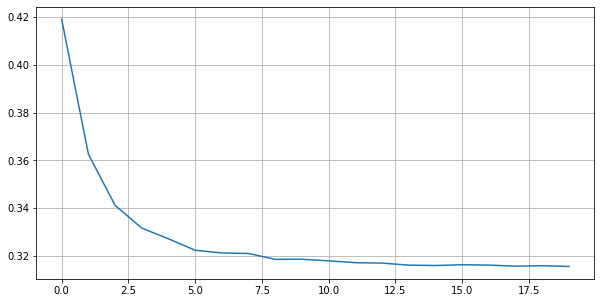

lr: 0.0005	loss: 0.3162298873066902   accu: 1.0


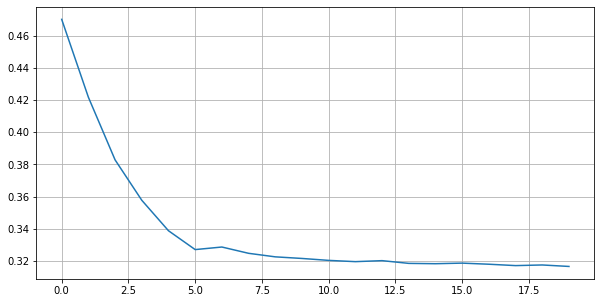

lr: 0.0001	loss: 0.31630075722932816   accu: 1.0


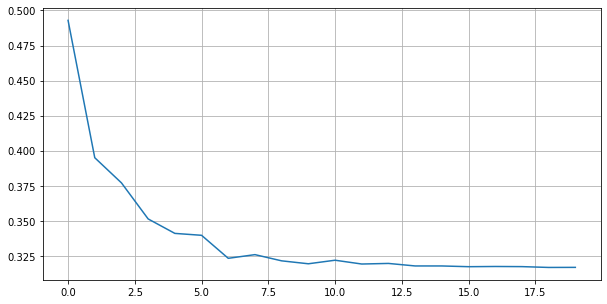

1.0 m  0.12979388236999512 s  

NETWORK: resnext50
lr: 0.001	loss: 0.3159124292433262   accu: 1.0


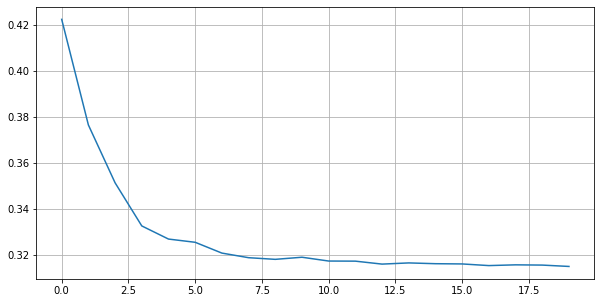

lr: 0.0005	loss: 0.31589699909090996   accu: 1.0


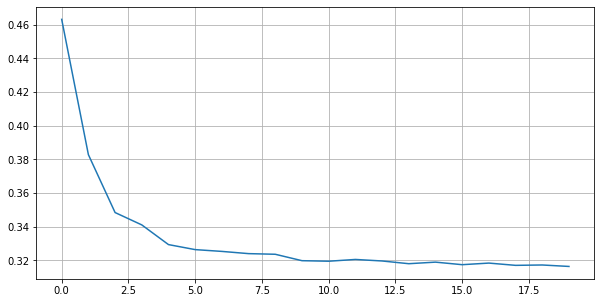

lr: 0.0001	loss: 0.315135408192873   accu: 1.0


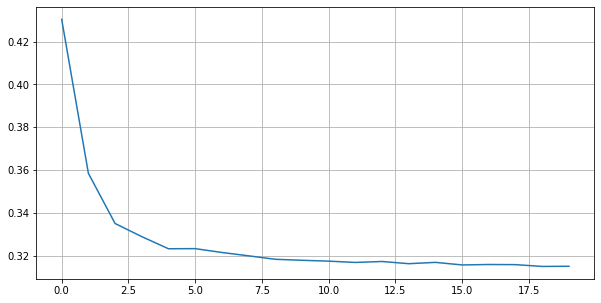

1.0 m  3.630016326904297 s  

NETWORK: wresnet50
lr: 0.001	loss: 0.3173474334180355   accu: 1.0


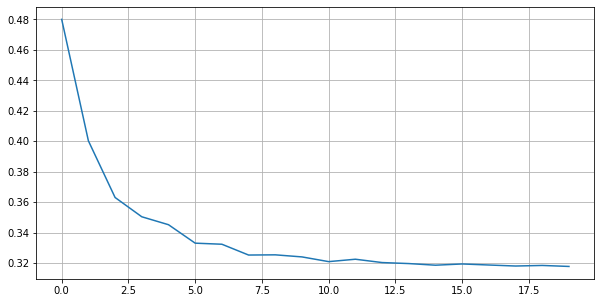

lr: 0.0005	loss: 0.3183940462768078   accu: 1.0


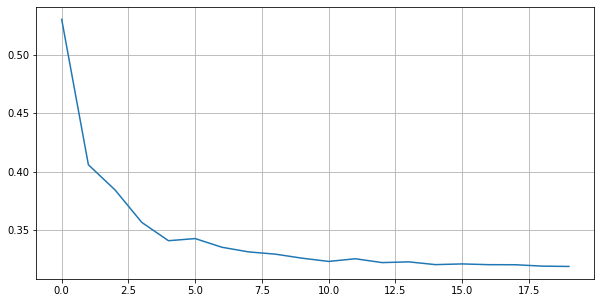

lr: 0.0001	loss: 0.3184083513915539   accu: 1.0


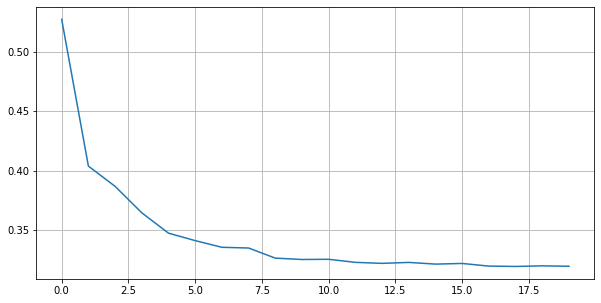

1.0 m  25.212113618850708 s  

NETWORK: inceptionresnetv2
lr: 0.001	loss: 0.3219420798122883   accu: 1.0


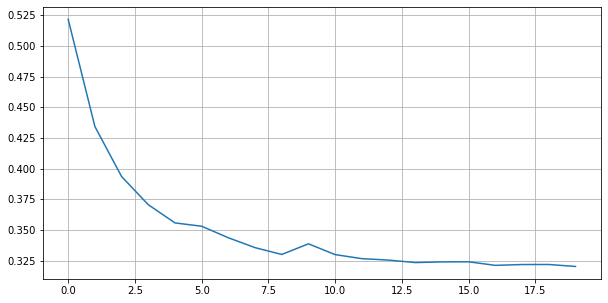

lr: 0.0005	loss: 0.3201818913221359   accu: 1.0


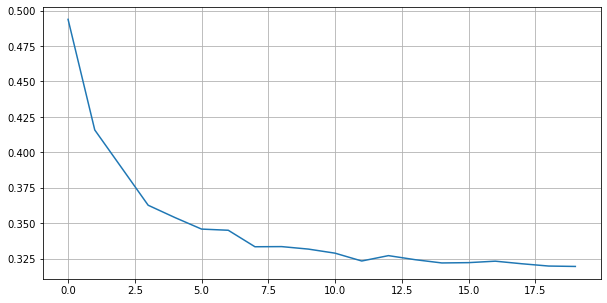

lr: 0.0001	loss: 0.32031501829624176   accu: 1.0


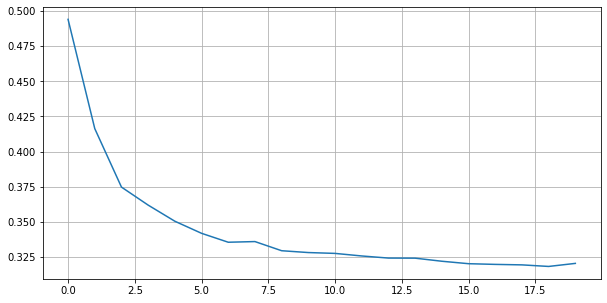

1.0 m  26.96875786781311 s  



In [51]:
learning_rates = [0.001,0.0005,0.0001]
for name in nets:
    print(f"NETWORK: {name}")
    t1 = time.time()
    net_tester(name, nets[name],dl_micro[TR],20, learning_rates, reseter)
    time_taken = time.time() - t1
    print(time_taken//60,'m ',time_taken % 60,'s ','\n')
load_sd(nets, nets_sd)

___

# Transfer Learning

In [0]:
import pandas as pd
from torchsummary import summary

In [0]:
def transfer_learn(model,params,lr,dl):
    optim = torch.optim.Adam(params,lr,weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,factor=0.5,patience=5,threshold=5e-5)
    loss_function = nn.CrossEntropyLoss()
    def prep(epochs):
         return fit(model,optim,sched,loss_function,dl,epochs)
    return prep

def plot_this(this,title):
    pd.DataFrame(this).plot(figsize=(10,5),title=title)

## Resnet 50

In [33]:
summary(nets['resnet50'],input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
tl_r50 = transfer_learn(nets['resnet50'],nets['resnet50'].fc.parameters(),0.001,dl)

In [35]:
epochs = 10
metrics_r50 = tl_r50(epochs)

 [1/10] | tr :: loss: 0.3477 accu: 0.9794 | va :: loss: 0.3271 accu: 0.9901 | time 119 s 498 ms
 [2/10] | tr :: loss: 0.3259 accu: 0.9910 | va :: loss: 0.3253 accu: 0.9876 | time 117 s 248 ms
 [3/10] | tr :: loss: 0.3248 accu: 0.9899 | va :: loss: 0.3246 accu: 0.9876 | time 116 s 496 ms
 [4/10] | tr :: loss: 0.3231 accu: 0.9918 | va :: loss: 0.3243 accu: 0.9876 | time 116 s 311 ms
 [5/10] | tr :: loss: 0.3218 accu: 0.9933 | va :: loss: 0.3239 accu: 0.9901 | time 115 s 861 ms
 [6/10] | tr :: loss: 0.3216 accu: 0.9933 | va :: loss: 0.3240 accu: 0.9901 | time 115 s 991 ms
 [7/10] | tr :: loss: 0.3218 accu: 0.9931 | va :: loss: 0.3239 accu: 0.9901 | time 115 s 922 ms
 [8/10] | tr :: loss: 0.3211 accu: 0.9939 | va :: loss: 0.3238 accu: 0.9901 | time 115 s 505 ms
 [9/10] | tr :: loss: 0.3214 accu: 0.9938 | va :: loss: 0.3238 accu: 0.9901 | time 115 s 011 ms
[10/10] | tr :: loss: 0.3218 accu: 0.9931 | va :: loss: 0.3238 accu: 0.9901 | time 115 s 007 ms
best accuracy: 0.9901 least loss: 0.3238

TypeError: ignored

batches (25): 
	  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
	 25
loss: 0.3216 accuracy: 0.9938


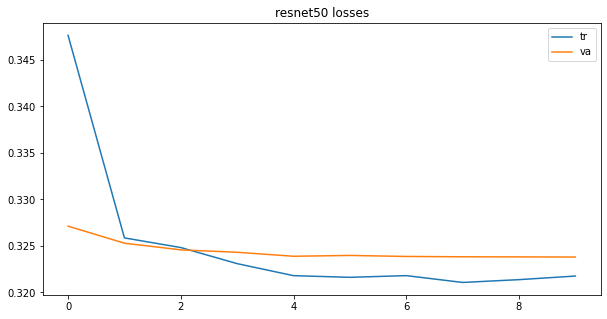

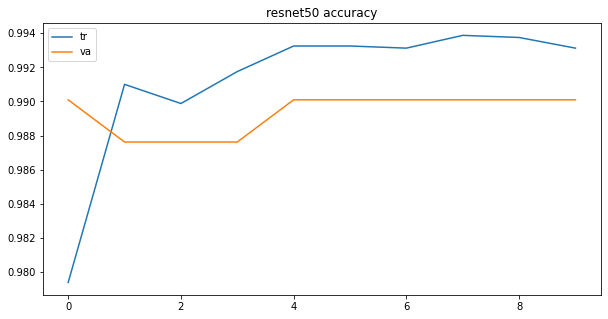

In [49]:
check_accu(nets['resnet50'],dl[TE])
losses_,accu_ = metrics_r50
plot_this(losses_,'resnet50 losses')
plot_this(accu_,'resnet50 accuracy')

## ResNext 50

In [50]:
summary(nets['resnext50'],input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
tl_rnx50 = transfer_learn(nets['resnext50'],nets['resnext50'].fc.parameters(),0.0001,dl)

In [52]:
epochs = 10
metrics_rnx50 = tl_rnx50(epochs)

 [1/10] | tr :: loss: 0.4755 accu: 0.9395 | va :: loss: 0.3808 accu: 0.9876 | time 123 s 286 ms
 [2/10] | tr :: loss: 0.3641 accu: 0.9869 | va :: loss: 0.3508 accu: 0.9876 | time 122 s 775 ms
 [3/10] | tr :: loss: 0.3455 accu: 0.9898 | va :: loss: 0.3410 accu: 0.9876 | time 122 s 714 ms
 [4/10] | tr :: loss: 0.3383 accu: 0.9898 | va :: loss: 0.3361 accu: 0.9876 | time 122 s 576 ms
 [5/10] | tr :: loss: 0.3347 accu: 0.9888 | va :: loss: 0.3332 accu: 0.9876 | time 122 s 814 ms
 [6/10] | tr :: loss: 0.3318 accu: 0.9900 | va :: loss: 0.3312 accu: 0.9876 | time 122 s 73 ms
 [7/10] | tr :: loss: 0.3298 accu: 0.9911 | va :: loss: 0.3304 accu: 0.9876 | time 122 s 531 ms
 [8/10] | tr :: loss: 0.3295 accu: 0.9900 | va :: loss: 0.3298 accu: 0.9876 | time 122 s 622 ms
 [9/10] | tr :: loss: 0.3284 accu: 0.9915 | va :: loss: 0.3292 accu: 0.9876 | time 122 s 576 ms
[10/10] | tr :: loss: 0.3279 accu: 0.9916 | va :: loss: 0.3290 accu: 0.9876 | time 122 s 089 ms
best accuracy: 0.9876 least loss: 0.3290


batches (25): 
	  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
	 25
loss: 0.3264 accuracy: 0.9938


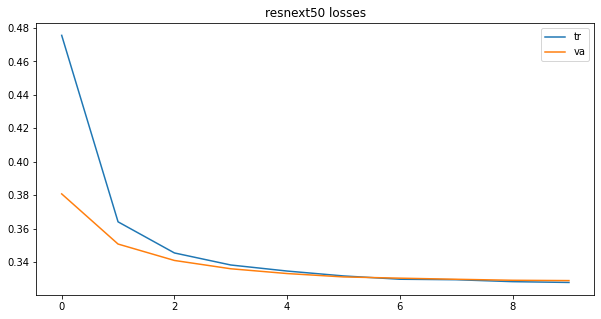

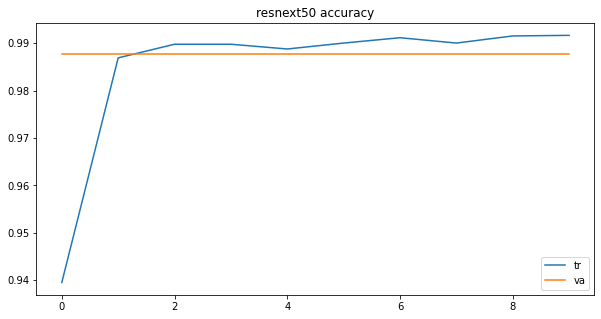

In [53]:
check_accu(nets['resnext50'],dl[TE])
losses_,accu_ = metrics_rnx50
plot_this(losses_,'resnext50 losses')
plot_this(accu_,'resnext50 accuracy')

## Wide Resnet 50

In [54]:
summary(nets['wresnet50'],input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
tl_wr50 = transfer_learn(nets['wresnet50'],nets['wresnet50'].fc.parameters(),0.001,dl)

In [56]:
epochs = 10
metrics_wr50 = tl_wr50(epochs)

 [1/10] | tr :: loss: 0.3482 accu: 0.9808 | va :: loss: 0.3242 accu: 0.9926 | time 134 s 722 ms
 [2/10] | tr :: loss: 0.3238 accu: 0.9921 | va :: loss: 0.3223 accu: 0.9926 | time 134 s 501 ms
 [3/10] | tr :: loss: 0.3215 accu: 0.9935 | va :: loss: 0.3216 accu: 0.9926 | time 134 s 775 ms
 [4/10] | tr :: loss: 0.3201 accu: 0.9946 | va :: loss: 0.3209 accu: 0.9926 | time 134 s 545 ms
 [5/10] | tr :: loss: 0.3192 accu: 0.9959 | va :: loss: 0.3210 accu: 0.9926 | time 134 s 323 ms
 [6/10] | tr :: loss: 0.3192 accu: 0.9955 | va :: loss: 0.3205 accu: 0.9926 | time 134 s 646 ms
 [7/10] | tr :: loss: 0.3194 accu: 0.9954 | va :: loss: 0.3211 accu: 0.9926 | time 134 s 681 ms
 [8/10] | tr :: loss: 0.3190 accu: 0.9969 | va :: loss: 0.3207 accu: 0.9926 | time 134 s 743 ms
 [9/10] | tr :: loss: 0.3187 accu: 0.9964 | va :: loss: 0.3208 accu: 0.9926 | time 134 s 513 ms
[10/10] | tr :: loss: 0.3184 accu: 0.9969 | va :: loss: 0.3208 accu: 0.9926 | time 134 s 812 ms
best accuracy: 0.9926 least loss: 0.3205

batches (25): 
	  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
	 25
loss: 0.3190 accuracy: 0.9969


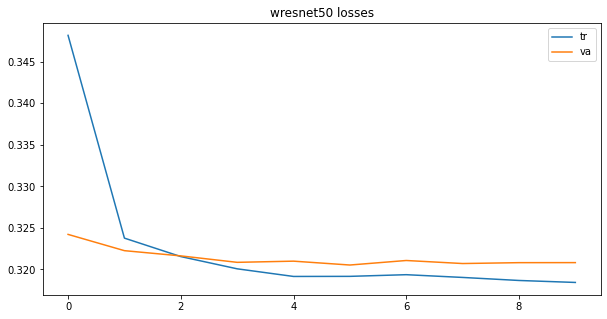

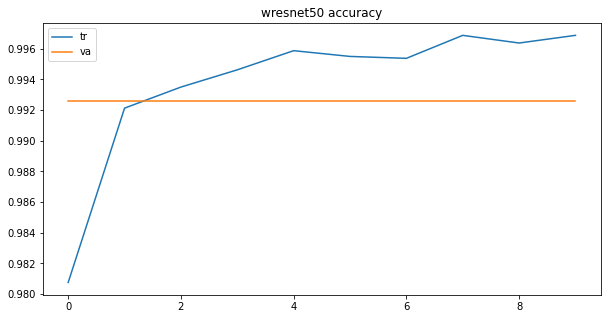

In [57]:
check_accu(nets['wresnet50'],dl[TE],)
losses_,accu_ = metrics_wr50
plot_this(losses_,'wresnet50 losses')
plot_this(accu_,'wresnet50 accuracy')

## Inception Resnet v2

In [58]:
summary(nets['inceptionresnetv2'],input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [0]:
tl_irv2 = transfer_learn(nets['inceptionresnetv2'],nets['inceptionresnetv2'].last_linear.parameters(),0.0005,dl)

In [60]:
epochs = 10
metrics_irv2 = tl_irv2(epochs)

 [1/10] | tr :: loss: 0.3560 accu: 0.9728 | va :: loss: 0.3347 accu: 0.9827 | time 133 s 327 ms
 [2/10] | tr :: loss: 0.3312 accu: 0.9850 | va :: loss: 0.3328 accu: 0.9777 | time 133 s 239 ms
 [3/10] | tr :: loss: 0.3286 accu: 0.9861 | va :: loss: 0.3308 accu: 0.9777 | time 133 s 064 ms
 [4/10] | tr :: loss: 0.3263 accu: 0.9889 | va :: loss: 0.3312 accu: 0.9802 | time 133 s 226 ms
 [5/10] | tr :: loss: 0.3272 accu: 0.9870 | va :: loss: 0.3303 accu: 0.9827 | time 133 s 485 ms
 [6/10] | tr :: loss: 0.3255 accu: 0.9893 | va :: loss: 0.3304 accu: 0.9827 | time 133 s 156 ms
 [7/10] | tr :: loss: 0.3252 accu: 0.9893 | va :: loss: 0.3301 accu: 0.9827 | time 133 s 824 ms
 [8/10] | tr :: loss: 0.3255 accu: 0.9890 | va :: loss: 0.3302 accu: 0.9827 | time 133 s 648 ms
 [9/10] | tr :: loss: 0.3257 accu: 0.9885 | va :: loss: 0.3302 accu: 0.9827 | time 133 s 838 ms
[10/10] | tr :: loss: 0.3255 accu: 0.9890 | va :: loss: 0.3301 accu: 0.9827 | time 133 s 647 ms
best accuracy: 0.9827 least loss: 0.3301

batches (25): 
	  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
	 25
loss: 0.3249 accuracy: 0.9895


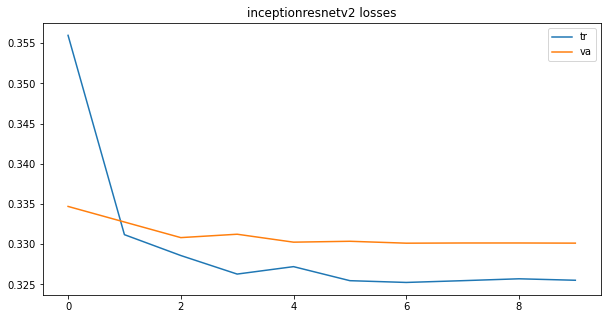

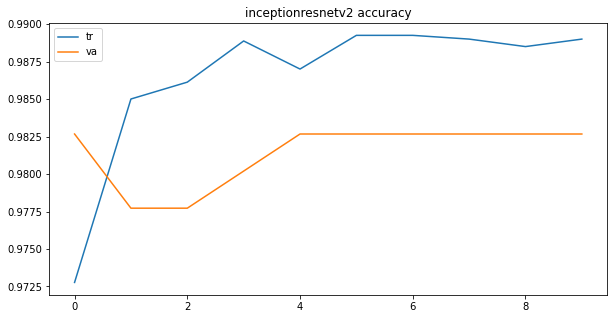

In [61]:
check_accu(nets['inceptionresnetv2'],dl[TE],)
losses_,accu_ = metrics_irv2
plot_this(losses_,'inceptionresnetv2 losses')
plot_this(accu_,'inceptionresnetv2 accuracy')

# Closing/ Conclusion

### Checking Accuracy and Inference times.

In [63]:
# Checking accuracy and loss of all the trained models.
check_all_accu(nets,dl[TE])

resnet50          : loss 0.32156161607747613  accu 0.993823347745522
resnext50         : loss 0.32640049577569286  accu 0.993823347745522
wresnet50         : loss 0.31897646028587595  accu 0.9969116738727609
inceptionresnetv2 : loss 0.32489372584612153  accu 0.9894996911673872


In [0]:
def check_inference_time(nets, count, device='cpu'):
    device = torch.device(device)
    net_times = {}
    for k in nets:
        batch_times = []
        nets[k].to(device)
        nets[k].eval()
        with torch.no_grad():
            for X in torch.rand(count,3,224,224):
                t = time.time()
                nets[k](X.view((1,*X.shape)).to(device))
                batch_times.append((time.time() - t))
        net_times[k] = np.array(batch_times).mean() * 1000
    return net_times

In [74]:
# Checking single inference not batch inference.
has_gpu = torch.cuda.is_available()
times_cpu = check_inference_time(nets, 30, 'cpu')
if has_gpu:
  times_gpu = check_inference_time(nets, 30, 'cuda:0')
  print("gpu used: ", torch.cuda.get_device_name())

for k in nets:
    print(f"{k.ljust(18)}:  cpu: {times_cpu[k]:0.6f} ms  ",end="")
    if has_gpu:
        print(f"gpu: {times_gpu[k]:0.6f} ms",end="")
    print()

gpu used:  Tesla T4
resnet50          :  cpu: 148.120077 ms  gpu: 9.743388 ms
resnext50         :  cpu: 166.773574 ms  gpu: 10.752074 ms
wresnet50         :  cpu: 324.215110 ms  gpu: 10.308393 ms
inceptionresnetv2 :  cpu: 250.603930 ms  gpu: 49.173331 ms


In [84]:
# Checking the network size in terms of parameter count.
print("param_count")
for k in nets:
    pc = 0
    for params in nets[k].parameters():
        for p in params:
            pc += len(p.reshape(-1))
    print(k.ljust(18),pc)

param_count
resnet50           23512130
resnext50          22984002
wresnet50          66838338
inceptionresnetv2  54309538


### Saving the weights

In [0]:
winning_net = deepcopy(nets['resnet50'])
torch.save(winning_net, 'resnet50_state_dict.pt')

#### Download the weights if Colab

In [0]:
files.download("resnet50_state_dict.pt")

## Conclusion

The Resnet 50 network although doesn't have the higest accuracy as compared to the Wide Resnet 50 (the difference is 0.0031) it has ~ 65% fewer parameters and the CPU inferece time is 2.2 times lesser which is substantial, hence it is the clear winner.